Theoretical orbit response to kick $\theta$:

$$C_{ij} = \theta_i \frac{ \sqrt{\beta_i \beta_j}}{2 \sin{\pi Q}} \cos(  2 \pi | \mu_i - \mu_j| - \pi Q) + \frac{\eta_i \eta_j}{\left( \alpha_C - \frac{1}{\gamma^2}\right) C}$$

LOCO needs to compute

$$M_x = \frac{\partial^2 x_i}{\partial \theta_j \partial k_{1,m}}$$
$$M_y = \frac{\partial^2 y_i}{\partial \theta_j \partial k_{1,m}}$$

where $\{\theta_j\}$ are orbit correctors hor. and vert.

and

$\{ k_{1,m}\}$ are quadrupole normal and skew used for correction, as many as there are power supplies

input:
perturb.param or script generating same
...

In [1]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from AT_ORM_tilt import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [2]:
# The lattice

from lattice3 import *
ring=at.Lattice(ring_old, energy=1)
ring.radiation_off()

preparing twiss ..
Tunes=[0.36170348 0.36337902]
Chrom=[-2.66149464 -1.93076457]


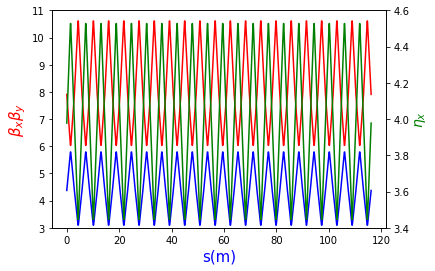

In [3]:
elements_indexes = get_refpts(ring, elements.Monitor)
twiss = getOptics(ring, '*', 'beta', 'False')

(40, 40)


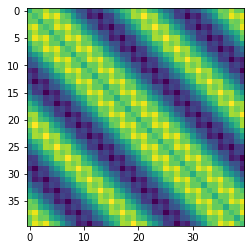

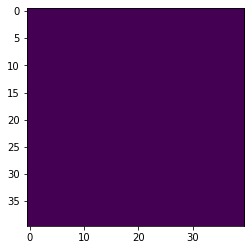

In [6]:
Cxx, Cxy= ORM_x(1.e-4, ring)
Cyy, Cyx= ORM_y(1.e-4, ring)

print(shape(Cxx))

plt.figure()
imshow(Cyy)
plt.show()

plt.figure()
imshow(Cxy)
plt.show()


In [7]:
quads_info = quad_info(ring)

Done...


In [8]:
ring[5]

Sextupole('SF', 0.01, 0.0)

In [9]:
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],0])
print(quad_vals[quads[iq],0])
eocc_a, vals = getQuadFamilies(quads_info)
print(eocc_a)
print(quad_vals[quads[iq],0])

Quadrupoles:['QF', 'QD']
QD 19
-2.1
-2.1
{'QF': 19, 'QD': 19}
-2.1


In [10]:
def computeOpticsD(ring, qname, i, dk):

    bpm_indexes = get_refpts(ring, elements.Monitor)
    quad_indexes = get_refpts(ring, qname)

    ring[quad_indexes[i]].K =  quad_vals[qname,i] + dk

    qxx, qxy= ORM_x(0.0001, ring)
    qyy, qyx= ORM_y(0.0001, ring)

    ring[quad_indexes[i]].K = quad_vals[qname,i]
    print(ring[quad_indexes[i]].K)

    return  qxx, qxy, qyy, qyx

In [11]:
%%time
# sequential version, this takes long:
# optimize with parallelization and separate function
# prepare

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname,i, dk)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

generating response to QF, n=19
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
1.7
generating response to QD, n=19
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
-2.1
Wall time: 42.6 s


In [12]:
from loco import getTheorOrm, getOrm
from pylab import *

C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
    nquad = quad_dict[qname]
    print('loading response to:',qname)
    for i in range(0,nquad+1):

        C1x = qxx[i]
        C1y = qyy[i]
        C1xy = qxy[i]
        C1yx = qyx[i]

        dCx.append( (C1x-C0x)  / dk)
        dCy.append( (C1y-C0y) /dk)
        dCxy.append( (C1xy-C0xy)/ dk)
        dCyx.append( (C1yx-C0yx)/ dk)

loading response to: QF
loading response to: QD


In [13]:
len(dCx)
dCx[1]

array([[-10.21312112,  -5.92757477,  -2.28373537, ...,   2.31421874,
         -2.5982124 ,  -6.01466738],
       [ -6.25279158,  -5.73411571,  -5.89694984, ...,   4.02777534,
          2.22148682,  -1.86886315],
       [ -2.5982124 ,  -6.01466738, -10.21312112, ...,   6.12648621,
          7.42032855,   2.31421874],
       ...,
       [  2.66149731,   4.1675724 ,   6.1842291 , ...,  -5.73411571,
         -5.89694984,  -1.55438612],
       [ -2.28373537,   2.46269384,   7.56012562, ...,  -6.01466738,
        -10.21312112,  -5.92757477],
       [ -5.89694984,  -1.55438612,   2.66149731, ...,  -1.86886315,
         -6.25279158,  -5.73411571]])

In [13]:
## simulate_errors

In [14]:
errorQF = 72.e-3 #0.01
errorQD = 52.e-3 #0.01
tiltQF = 0.0003
tiltQD = 0.0003

quads_info_error = simulateError(ring,errorQF,errorQD, tiltQF, tiltQD)

simulating perturbed machine...
Done...


preparing twiss ..
Tunes=[0.44494672 0.87268496]
Chrom=[-4.6212015  -4.05187652]


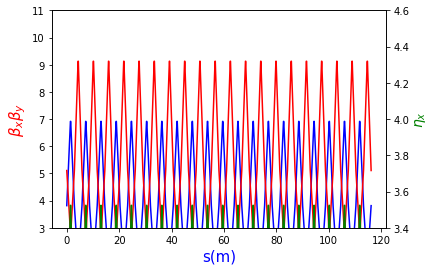

In [15]:
twiss_error = getOptics(ring, '*', 'beta', 'True')

In [16]:
#Cell2

In [16]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-4, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-4, ring)

print(shape(Cxx_err))

(40, 40)


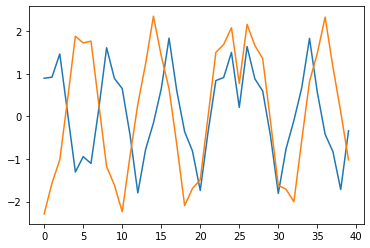

In [17]:
plt.plot(Cxx_err[25])
plt.plot((Cxx[25]))
plt.show()
#plt.imshow(Cxx_err)
plt.show()

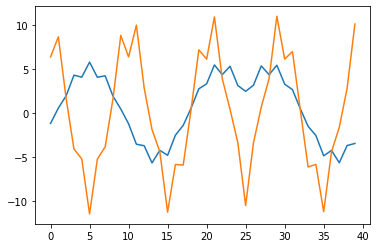

In [18]:
plt.plot(Cyy[25])
plt.plot((Cyy_err[25]))
plt.show()
#plt.imshow(Cyy_err)

In [19]:
print(np.max(Cyy_err-Cyy))

13.586564458544148


In [22]:
#Cell4

In [20]:
#A, B = build_matrix(ormx, ormy, C0x, C0x, C0x, dCx, dCy, dCxy, Cyx, ormx, ormy)


Nk = len(dCx) #number of free parameters (number of quads or g_k)
Nm = 40 # number of measurements (iteration) ######### #######
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk]) # (160, 40) ###########


NK: 40
Nm: 40


In [21]:
Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])


In [22]:
Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

In [23]:
for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

In [24]:
for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

number of singular values 40
A(160, 40) B(160, 1) U(160, 160) smat(160, 40) v(40, 40)


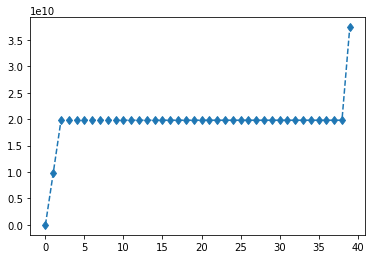

In [26]:
u,s,v=np.linalg.svd(A,  full_matrices=True)

smat = 0.0 * A
si = s**-1
#n_sv = 20
#si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(si,'d--')
plt.show()

In [27]:
si

array([1.95379161e-06, 9.79785818e+09, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 1.98026446e+10,
       1.98026446e+10, 1.98026446e+10, 1.98026446e+10, 3.73848884e+10])

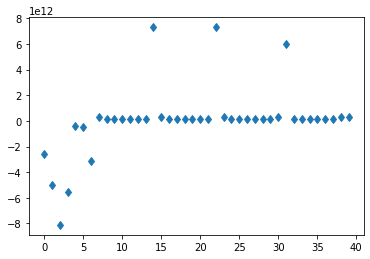

In [28]:
Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()

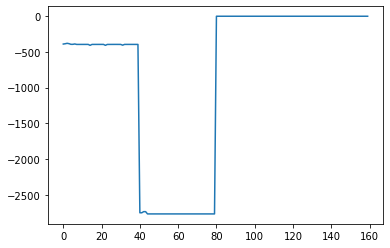

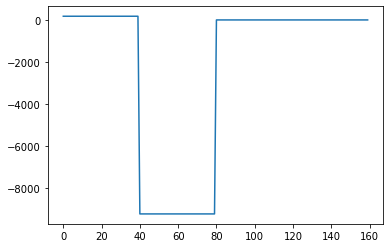

In [29]:
# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()

In [30]:
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
quads = [ k for k in quad_dict.keys()]
print(f"Quadrupoles:{quads}")
iq = 1
print(quads[iq], quad_dict[quads[iq]])
print(quad_vals[quads[iq],1])
print(quad_vals[quads[iq],1])
eocc_a, vals = getQuadFamilies(quads_info_error)
print(eocc_a)
print(quad_vals[quads[iq],1])

Quadrupoles:['QF', 'QD']
QD 20
-3.8223408652593927
-3.8223408652593927
{'QF': 20, 'QD': 20}
-3.8223408652593927


In [31]:
# check correction...


n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

40


In [32]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)

In [33]:
quads_indexes = get_refpts(ring, elements.Quadrupole)
i = 0
while (i < len(quads_indexes)):

      print(ring[quads_indexes[i]].K)
      ring[quads_indexes[i]].K += DK[i]
      print(ring[quads_indexes[i]].K)
      i += 1


3.4364404816988756
2619191608373.968
-3.8223408652593927
-121209485177.2989
2619191608373.968
7595596727203.921
-121209485177.2989
-242418970350.79108
7595596727203.921
15710644426649.14
-242418970350.79108
-7548307019009.612
15710644426649.14
21230910273246.547
-7548307019009.612
-7836248307114.405
21230910273246.547
21654140227682.312
-7836248307114.405
-7957457792287.46
21654140227682.312
22137718230414.5
-7957457792287.46
-8078667277460.765
22137718230414.5
25246305056619.33
-8078667277460.765
-8199876762633.874
25246305056619.33
24947751487293.016
-8199876762633.874
-8321086247806.983
24947751487293.016
24826542002119.367
-8321086247806.983
-8442295732980.108
24826542002119.367
24705332516945.945
-8442295732980.108
-8563505218153.429
24705332516945.945
24584123031772.54
-8563505218153.429
-8851446506257.43
24584123031772.54
24462913546598.93
-8851446506257.43
-14838687811545.852
24462913546598.93
24341704061425.492
-14838687811545.852
-14959897296719.586
24341704061425.492
2422049

preparing twiss ..
Tunes=[0.41042869 0.35477196]
Chrom=[-2.71905548 -1.97731198]


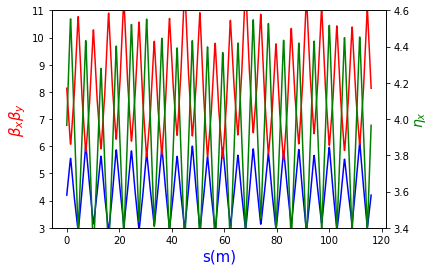

In [31]:
twiss_corrected = getOptics(ring, '*', 'beta', 'True')

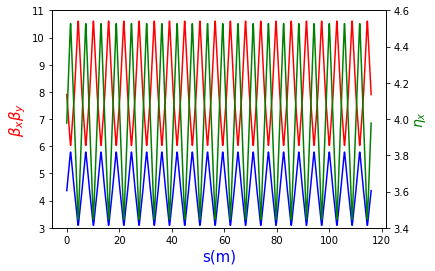

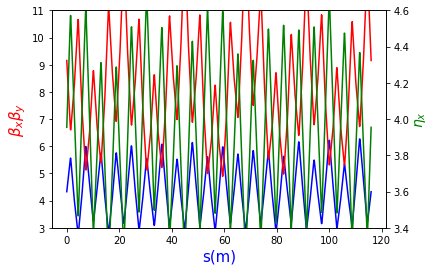

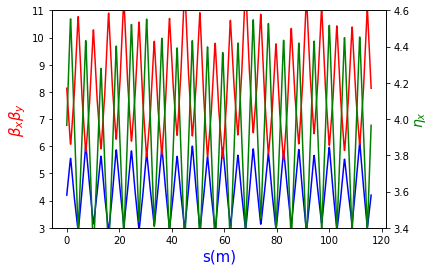

In [32]:
fig, ax = plt.subplots()
ax.plot(twiss.s_pos,  twiss.betax, color="blue")
ax.plot(twiss.s_pos,  twiss.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(twiss.s_pos, twiss.dx, color="green")
ax2.set_ylabel(r'$\eta_x$', color="green", fontsize=14)
ax2.set_ylim([3.4, 4.6])
plt.show()




fig, ax = plt.subplots()
ax.plot(twiss_error.s_pos,  twiss_error.betax, color="blue")
ax.plot(twiss_error.s_pos,  twiss_error.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(twiss_error.s_pos, twiss_error.dx, color="green")
ax2.set_ylabel(r'$\eta_x$', color="green", fontsize=14)
ax2.set_ylim([3.4, 4.6])
plt.show()



fig, ax = plt.subplots()
ax.plot(twiss_corrected.s_pos,  twiss_corrected.betax, color="blue")
ax.plot(twiss_corrected.s_pos,  twiss_corrected.betay, color="red")
ax.set_xlabel(r's(m)', color="blue", fontsize=15)
ax.set_ylabel(r'$\beta_x$', color="blue", fontsize=15)
ax.set_ylim([3, 11])
ax.set_ylabel(r'$\beta_x \beta_y$', color="red", fontsize=15)

# twin object for two different y-axis on the sample plot
ax2 = ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(twiss_corrected.s_pos, twiss_corrected.dx, color="green")
ax2.set_ylabel(r'$\eta_x$', color="green", fontsize=14)
ax2.set_ylim([3.4, 4.6])
plt.show()

In [33]:
twiss_error

,s_pos,betax,betay,dx,dy
0,0.0,4.328349,9.155305,3.954563,0.440191
1,1.3,5.481025,6.780320,4.526423,0.432347
2,1.3,5.481025,6.780320,4.526423,0.432347
3,1.4,5.563365,6.630264,4.569658,0.432347
4,1.4,5.563365,6.630264,4.569658,0.432347
...,...,...,...,...,...
276,114.5,3.210230,12.597319,3.356325,-0.327981
277,114.5,3.210230,12.597319,3.356325,-0.327981
278,114.6,3.197825,12.594127,3.360166,0.404946
279,114.7,3.261818,12.318193,3.400661,0.404946


In [34]:
twiss_corrected

,s_pos,betax,betay,dx,dy
0,0.0,4.201953,8.134056,3.965844,0.420083
1,1.3,5.461631,6.197261,4.511441,0.412381
2,1.3,5.461631,6.197261,4.511441,0.412381
3,1.4,5.554171,6.079055,4.552679,0.412381
4,1.4,5.554171,6.079055,4.552679,0.412381
...,...,...,...,...,...
276,114.5,3.047744,11.050859,3.396534,-0.348555
277,114.5,3.047744,11.050859,3.396534,-0.348555
278,114.6,3.038174,11.050844,3.398436,0.386665
279,114.7,3.101275,10.813923,3.437102,0.386665
